In [1]:

import os, shutil
from glob import glob
import numpy as np
import pandas as pd
from natsort import natsorted
import seaborn as sns
from tqdm import tqdm, trange
import matplotlib.pyplot as plt


In [2]:

in_dir = "out01_tms_induced_respose/"
in_dir2 = "data_subject_info/"

out_dir = "out02_correlation_and_scatterplot/"
in_file_name = "HRF_tms_induced_response.csv"

if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    
complete_df = pd.read_csv(in_dir + in_file_name)

subject_info = pd.read_csv(in_dir2 + "age_gender_edu.txt", sep = ',')
intensity_suds = pd.read_csv(in_dir2 + "intensity_suds.csv", sep = ',')
scalp_dist = pd.read_csv(in_dir2 + "dist_to_scalp.csv", sep = ',')
print(list(scalp_dist['site'].drop_duplicates()))


['L-FP', 'R-FP', 'L-aMFG', 'R-aMFG', 'L-pMFG', 'R-pMFG', 'R-IFJ', 'R-FEF', 'R-M1', 'R-preSMA', 'R-IPL']


In [3]:
tms_sites = ["L_Fp","R_Fp","L_aMFG","R_aMFG","L_pMFG","R_pMFG","R_IFJ","R_FEF","R_M1","R_preSMA","R_IPL"]

# scalp_dist['site'] = scalp_dist['site'].str.replace('-', '_')
scalp_dist['site'].replace(list(scalp_dist['site'].drop_duplicates()), tms_sites, inplace = True)
# df['range'].str.replace(',','-')

# reformat columns in intensity_suds:
intensity_suds = pd.melt(intensity_suds, id_vars=['idall', 'MT', 'intensity'], value_vars = tms_sites,
                         var_name = 'suds_site', value_name = 'suds')

data = subject_info.merge(complete_df, left_on = 'cc_post_intake_id', right_on = 'subject')
data = data.merge(intensity_suds, how = 'left', 
                  left_on = ['cc_post_intake_id', 'site'], right_on = ['idall', 'suds_site'])

data = data.merge(scalp_dist, how = 'left', 
                  left_on = ['subject', 'site'], right_on = ['subject', 'site'])

data.drop(labels = ['inputfile', 'idall', 'cc_post_intake_id', 'suds_site'], axis = 1, inplace = True)
data.replace({'gender': {1: "male", 2: "female"}}, inplace = True)
data


,gender,age,yrs_of_edu,subject,site,group,tms_site_response_standard,tms_site_response_individual_6mm,tms_site_response_individual_10mm,tms_site_response_individual_14mm,tms_site_response_individual_14-10mm,tms_site_response_individual_10-6mm,MT,intensity,suds,scalp_dist
0,female,45,18,1001,L_Fp,NTHC,0.287125,0.439684,0.456288,0.395807,0.354767,0.462649,62.0,74.0,10.0,14.749354
1,female,45,18,1001,L_pMFG,NTHC,-0.358279,-0.463813,-0.439631,-0.329946,-0.264645,-0.431570,62.0,74.0,5.0,13.038824
2,female,45,18,1001,R_FEF,NTHC,-0.252532,-0.423779,-0.511036,-0.496599,-0.487678,-0.540984,62.0,74.0,2.0,17.079627
3,female,45,18,1001,R_Fp,NTHC,0.245202,0.278052,0.265166,0.243850,0.230372,0.260594,62.0,74.0,7.0,16.614293
4,female,45,18,1001,R_M1,NTHC,-1.002989,-1.403756,-1.606550,-1.550770,-1.520768,-1.663231,62.0,74.0,1.0,15.276347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,male,22,14,2108,R_IPL,TEHC,1.236482,0.391417,1.001566,1.383794,1.611196,1.196951,NaN,100.0,5.0,14.361543
788,male,22,14,2108,R_M1,TEHC,0.124382,0.233850,0.166974,0.150504,0.140419,0.144036,NaN,100.0,15.0,18.975313
789,male,22,14,2108,R_aMFG,TEHC,-0.279814,-0.045608,-0.032161,-0.082834,-0.115168,-0.027050,NaN,100.0,20.0,13.567683
790,male,22,14,2108,R_pMFG,TEHC,0.363362,-0.020677,0.119496,0.184963,0.224639,0.165267,NaN,100.0,20.0,14.366030


In [9]:
## pairwise correlation:
from scipy.stats import pearsonr
from IPython.display import display

corr_x1 = ['tms_site_response_standard', 'tms_site_response_individual_6mm',
           'tms_site_response_individual_10mm', 'tms_site_response_individual_14mm', 
           'tms_site_response_individual_14-10mm', 'tms_site_response_individual_10-6mm']

corr_x2 = ['age', 'yrs_of_edu', 'intensity', 'MT', 'scalp_dist', 'suds']
tms_sites = ["L_Fp","R_Fp","L_aMFG","R_aMFG","L_pMFG","R_pMFG","R_IFJ","R_FEF","R_M1","R_preSMA","R_IPL"]

for x1 in corr_x1:
    row_index = pd.MultiIndex.from_tuples([(i , j) for i in corr_x2 for j in ["Pearson's r", 'p value']])
    result = pd.DataFrame(index = row_index, columns = tms_sites)
    for site in tms_sites:
        for x2 in corr_x2:
            x1_val = data.loc[data['site'] == site, x1].values
            x2_val = data.loc[data['site'] == site, x2].values
            
            idx_nan = np.isnan(x1_val) | np.isnan(x2_val)
            r, p = pearsonr(x1_val[~idx_nan], x2_val[~idx_nan])
            result.loc[(x2, "Pearson's r"), site] = "%.3f" % r
            result.loc[(x2, 'p value'), site] = "%.3f" % p + ('*' if p < .05 else '')
            
            result.to_csv(out_dir + 'correlation_' + x1 + '.csv')
    print(x1)
    display(result)

tms_site_response_standard


L_Fp    R_Fp  L_aMFG  R_aMFG  L_pMFG  R_pMFG  \
age        Pearson's r  -0.062   0.092   0.162   0.187   0.111  -0.048   
           p value       0.627   0.453   0.159   0.100   0.330   0.678   
yrs_of_edu Pearson's r  -0.143  -0.006   0.145   0.193   0.112   0.072   
           p value       0.260   0.961   0.209   0.089   0.326   0.527   
intensity  Pearson's r  -0.170  -0.072  -0.103   0.027  -0.023   0.004   
           p value       0.179   0.560   0.371   0.813   0.838   0.969   
MT         Pearson's r  -0.314  -0.020  -0.077  -0.013   0.056   0.076   
           p value      0.031*   0.891   0.572   0.925   0.671   0.566   
scalp_dist Pearson's r  -0.159  -0.083  -0.101   0.182   0.129   0.041   
           p value       0.259   0.545   0.411   0.128   0.290   0.735   
suds       Pearson's r   0.119  -0.116   0.041   0.131   0.022   0.035   
           p value       0.347   0.355   0.723   0.254   0.845   0.760   

                         R_IFJ   R_FEF    R_M1 R_preSMA   R_IPL  
age        Pearson's r   0.018   0.011   0.017   -0.077   0.058  
           p value       0.881   0.927   0.881    0.544   0.686  
yrs_of_edu Pearson's r   0.086   0.167  -0.098    0.048   0.136  
           p value       0.461   0.145   0.391    0.708   0.342  
intensity  Pearson's r   0.105   0.036  -0.020   -0.080  -0.206  
           p value       0.371   0.754   0.863    0.532   0.147  
MT         Pearson's r   0.002  -0.014  -0.065   -0.143  -0.123  
           p value       0.991   0.918   0.626    0.331   0.487  
scalp_dist Pearson's r   0.037  -0.191  -0.082    0.086  -0.129  
           p value       0.767   0.122   0.502    0.525   0.404  
suds       Pearson's r  -0.135   0.015  -0.010    0.005  -0.236  
           p value       0.251   0.900   0.933    0.967   0.143

tms_site_response_individual_6mm


L_Fp    R_Fp  L_aMFG  R_aMFG  L_pMFG  R_pMFG  \
age        Pearson's r  -0.179   0.142   0.300   0.111  -0.005  -0.040   
           p value       0.205   0.325  0.013*   0.357   0.970   0.746   
yrs_of_edu Pearson's r  -0.250   0.063   0.217   0.051   0.110   0.037   
           p value       0.074   0.666   0.076   0.676   0.371   0.763   
intensity  Pearson's r  -0.176  -0.082  -0.267  -0.049   0.010  -0.037   
           p value       0.213   0.572  0.028*   0.684   0.938   0.762   
MT         Pearson's r  -0.154  -0.144  -0.235  -0.186   0.050   0.082   
           p value       0.369   0.424   0.108   0.186   0.735   0.575   
scalp_dist Pearson's r  -0.084  -0.077  -0.151  -0.005  -0.108   0.006   
           p value       0.552   0.596   0.218   0.964   0.379   0.960   
suds       Pearson's r   0.316  -0.027  -0.023   0.128  -0.148  -0.113   
           p value      0.023*   0.853   0.854   0.289   0.230   0.358   

                         R_IFJ   R_FEF    R_M1 R_preSMA   R_IPL  
age        Pearson's r   0.074  -0.002   0.099   -0.161   0.185  
           p value       0.557   0.984   0.421    0.232   0.230  
yrs_of_edu Pearson's r  -0.055   0.124  -0.170   -0.035   0.049  
           p value       0.659   0.318   0.165    0.795   0.750  
intensity  Pearson's r   0.159   0.035  -0.080   -0.125  -0.420  
           p value       0.201   0.776   0.514    0.356  0.005*  
MT         Pearson's r   0.005  -0.095  -0.099   -0.184  -0.315  
           p value       0.972   0.522   0.497    0.250   0.102  
scalp_dist Pearson's r  -0.052  -0.160  -0.045   -0.003  -0.233  
           p value       0.678   0.197   0.713    0.979   0.129  
suds       Pearson's r  -0.113   0.006  -0.082   -0.032  -0.112  
           p value       0.369   0.965   0.521    0.811   0.536

tms_site_response_individual_10mm


L_Fp    R_Fp  L_aMFG  R_aMFG  L_pMFG  R_pMFG  \
age        Pearson's r  -0.136   0.076   0.290   0.118   0.015  -0.083   
           p value       0.336   0.579  0.016*   0.326   0.900   0.492   
yrs_of_edu Pearson's r  -0.277   0.076   0.228   0.114   0.096   0.026   
           p value      0.047*   0.580   0.061   0.344   0.432   0.833   
intensity  Pearson's r  -0.121  -0.012  -0.278  -0.022   0.030  -0.015   
           p value       0.392   0.931  0.022*   0.855   0.806   0.900   
MT         Pearson's r  -0.074   0.061  -0.274  -0.157   0.109   0.113   
           p value       0.668   0.721   0.060   0.266   0.452   0.432   
scalp_dist Pearson's r  -0.133  -0.065  -0.137   0.043  -0.033   0.001   
           p value       0.349   0.638   0.264   0.719   0.787   0.992   
suds       Pearson's r   0.322   0.007  -0.011   0.111  -0.135  -0.072   
           p value      0.020*   0.962   0.932   0.361   0.270   0.555   

                         R_IFJ   R_FEF    R_M1 R_preSMA   R_IPL  
age        Pearson's r   0.096   0.031   0.059   -0.170   0.160  
           p value       0.444   0.802   0.627    0.205   0.300  
yrs_of_edu Pearson's r   0.047   0.181  -0.154   -0.014   0.088  
           p value       0.708   0.143   0.204    0.919   0.570  
intensity  Pearson's r   0.190   0.014  -0.015   -0.118  -0.323  
           p value       0.127   0.908   0.900    0.380  0.033*  
MT         Pearson's r   0.019  -0.063  -0.058   -0.196  -0.254  
           p value       0.899   0.672   0.687    0.220   0.193  
scalp_dist Pearson's r  -0.026  -0.177  -0.057    0.035  -0.249  
           p value       0.833   0.153   0.638    0.797   0.103  
suds       Pearson's r  -0.097   0.006  -0.037   -0.004  -0.167  
           p value       0.441   0.961   0.768    0.976   0.352

tms_site_response_individual_14mm


L_Fp    R_Fp  L_aMFG  R_aMFG  L_pMFG  R_pMFG  \
age        Pearson's r  -0.107   0.035   0.276   0.104   0.066  -0.075   
           p value       0.452   0.802  0.023*   0.387   0.591   0.537   
yrs_of_edu Pearson's r  -0.287   0.066   0.226   0.152   0.084   0.028   
           p value      0.039*   0.630   0.063   0.205   0.495   0.820   
intensity  Pearson's r  -0.099  -0.023  -0.259  -0.014   0.019  -0.002   
           p value       0.485   0.866  0.033*   0.908   0.875   0.986   
MT         Pearson's r  -0.043   0.044  -0.282  -0.119   0.121   0.112   
           p value       0.801   0.797   0.052   0.399   0.402   0.432   
scalp_dist Pearson's r  -0.144  -0.072  -0.096   0.063   0.041  -0.008   
           p value       0.308   0.600   0.435   0.600   0.740   0.947   
suds       Pearson's r   0.317  -0.003   0.013   0.085  -0.103  -0.024   
           p value      0.022*   0.986   0.918   0.484   0.402   0.845   

                         R_IFJ   R_FEF    R_M1 R_preSMA   R_IPL  
age        Pearson's r   0.095   0.092   0.040   -0.176   0.089  
           p value       0.447   0.461   0.745    0.191   0.568  
yrs_of_edu Pearson's r   0.108   0.210  -0.138    0.013   0.106  
           p value       0.386   0.088   0.256    0.926   0.494  
intensity  Pearson's r   0.196  -0.013   0.021   -0.095  -0.213  
           p value       0.115   0.918   0.864    0.482   0.165  
MT         Pearson's r   0.030  -0.028  -0.042   -0.186  -0.139  
           p value       0.843   0.852   0.770    0.244   0.481  
scalp_dist Pearson's r   0.000  -0.203  -0.056    0.078  -0.257  
           p value       1.000   0.099   0.648    0.564   0.092  
suds       Pearson's r  -0.100  -0.012  -0.047    0.020  -0.254  
           p value       0.429   0.922   0.710    0.884   0.154

tms_site_response_individual_14-10mm


L_Fp    R_Fp  L_aMFG  R_aMFG  L_pMFG  R_pMFG  \
age        Pearson's r  -0.091   0.014   0.257   0.088   0.100  -0.064   
           p value       0.520   0.920  0.034*   0.466   0.413   0.597   
yrs_of_edu Pearson's r  -0.281   0.058   0.216   0.168   0.075   0.029   
           p value      0.043*   0.674   0.077   0.161   0.543   0.812   
intensity  Pearson's r  -0.083  -0.022  -0.239  -0.008   0.015   0.006   
           p value       0.558   0.872  0.049*   0.950   0.903   0.961   
MT         Pearson's r  -0.022   0.048  -0.279  -0.089   0.131   0.113   
           p value       0.899   0.776   0.055   0.529   0.365   0.430   
scalp_dist Pearson's r  -0.147  -0.070  -0.065   0.075   0.089  -0.017   
           p value       0.298   0.614   0.597   0.533   0.469   0.890   
suds       Pearson's r   0.308  -0.005   0.030   0.069  -0.075   0.004   
           p value      0.026*   0.974   0.810   0.572   0.542   0.972   

                         R_IFJ   R_FEF    R_M1 R_preSMA   R_IPL  
age        Pearson's r   0.094   0.123   0.029   -0.177   0.037  
           p value       0.451   0.320   0.813    0.187   0.813  
yrs_of_edu Pearson's r   0.141   0.219  -0.124    0.030   0.106  
           p value       0.258   0.075   0.305    0.824   0.493  
intensity  Pearson's r   0.196  -0.024   0.046   -0.080  -0.128  
           p value       0.115   0.845   0.703    0.554   0.408  
MT         Pearson's r   0.036  -0.008  -0.029   -0.180  -0.047  
           p value       0.811   0.956   0.840    0.259   0.812  
scalp_dist Pearson's r   0.018  -0.212  -0.057    0.104  -0.260  
           p value       0.886   0.085   0.641    0.441   0.088  
suds       Pearson's r  -0.097  -0.024  -0.046    0.033  -0.297  
           p value       0.442   0.850   0.714    0.805   0.093

tms_site_response_individual_10-6mm


L_Fp    R_Fp  L_aMFG  R_aMFG  L_pMFG  R_pMFG  \
age        Pearson's r  -0.128   0.077   0.280   0.115   0.026  -0.091   
           p value       0.366   0.578  0.021*   0.339   0.834   0.454   
yrs_of_edu Pearson's r  -0.277   0.077   0.226   0.131   0.087   0.019   
           p value      0.046*   0.577   0.063   0.277   0.476   0.874   
intensity  Pearson's r  -0.106  -0.011  -0.280  -0.014   0.034  -0.010   
           p value       0.453   0.935  0.021*   0.907   0.778   0.934   
MT         Pearson's r  -0.049   0.067  -0.283  -0.144   0.124   0.121   
           p value       0.775   0.693   0.051   0.308   0.390   0.398   
scalp_dist Pearson's r  -0.141  -0.064  -0.129   0.057  -0.008  -0.005   
           p value       0.320   0.642   0.293   0.636   0.947   0.967   
suds       Pearson's r   0.319   0.005  -0.005   0.103  -0.123  -0.059   
           p value      0.021*   0.973   0.969   0.395   0.314   0.627   

                         R_IFJ   R_FEF    R_M1 R_preSMA   R_IPL  
age        Pearson's r   0.102   0.037   0.053   -0.171   0.143  
           p value       0.416   0.769   0.665    0.204   0.355  
yrs_of_edu Pearson's r   0.078   0.192  -0.147   -0.007   0.096  
           p value       0.532   0.119   0.224    0.960   0.534  
intensity  Pearson's r   0.196   0.011  -0.002   -0.117  -0.277  
           p value       0.115   0.931   0.989    0.388   0.069  
MT         Pearson's r   0.022  -0.059  -0.054   -0.200  -0.223  
           p value       0.886   0.690   0.710    0.209   0.253  
scalp_dist Pearson's r  -0.016  -0.181  -0.061    0.045  -0.256  
           p value       0.900   0.143   0.617    0.739   0.094  
suds       Pearson's r  -0.089   0.008  -0.034    0.005  -0.186  
           p value       0.480   0.951   0.784    0.973   0.301

In [5]:
test_variables = ['tms_site_response_standard', 'tms_site_response_individual_6mm',
                  'tms_site_response_individual_10mm', 'tms_site_response_individual_14mm', 
                  'tms_site_response_individual_14-10mm', 'tms_site_response_individual_10-6mm']

plot_data = pd.melt(data, id_vars = ['subject', 'site', 'gender', 'suds'] + test_variables, 
                    value_vars = ['age', 'yrs_of_edu', 'intensity', 'MT', 'scalp_dist'], 
                    var_name = 'metrics', value_name='values')

plot_data.groupby('metrics')['values'].count()


metrics
MT            581
age           792
intensity     792
scalp_dist    689
yrs_of_edu    792
Name: values, dtype: int64

In [6]:
## scatter plots:
sns.set(rc={'figure.figsize':(5.2 * 11, 5.2 * 6)}, font_scale = 1.15)

from scipy.stats import pearsonr
# we don't need partial correlation this could be eliminated to make the code cleaner
from pingouin import partial_corr 

tms_sites = data['site'].unique()
colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(tms_sites)).as_hex()
colors = colors[1::2] + colors[2::2] 
scatter_para = {'alpha': 0.7, 's': 30, 'linewidth': 0.2}

def scatter_plot(plot_data, ylabel, method = 'correlation'):
    
    g = sns.lmplot(x = 'values', y = ylabel, hue = 'site', 
                   row = 'site', col = 'metrics', palette = colors, 
                   data = plot_data, fit_reg = True, sharex = False, sharey = True, \
                   scatter_kws=scatter_para, 
                   line_kws = {'lw': 2},
                   x_jitter = .2, order = 1,\
                   height=3.27, aspect=1, legend = False)
    
    # compute R squared for each group and cluster:
    column_title = plot_data['metrics'].unique()
    
    x_pos = [18, 12, 71, 48, 7, -5]
    x_lim = [[16, 62], [11.5, 18.5], [69, 102], [46, 85], [6, 25], [-10, 100]]
    
    for col in range(len(column_title)):
        for row in range(len(tms_sites)):
            x = plot_data.loc[(plot_data['site']==tms_sites[row])&(plot_data['metrics']==column_title[col]), 
                              'values'].values
            y = plot_data.loc[(plot_data['site']==tms_sites[row])&(plot_data['metrics']==column_title[col]), 
                              ylabel].values
                        
            if method == 'correlation':
                idx_nan = np.isnan(x) | np.isnan(y)
                r, p = pearsonr(x[~idx_nan], y[~idx_nan])
                label = "$r$ = %.3f, $p$ = %.3f" % (r, p)
                if p < .05:
                    label += '*'
            else: # partial correlation:
                z = plot_data.loc[(plot_data['site']==tms_sites[row])&(plot_data['metrics']==column_title[col]), 
                              'suds'].values
                
                idx_nan = np.isnan(x) | np.isnan(y) | np.isnan(z)
                df = pd.DataFrame({'x': x[~idx_nan], 'y': y[~idx_nan], 'z': z[~idx_nan]})
                res = partial_corr(df, x = 'x', y = 'y', covar = 'z')
                label = "$r$ = %.3f, $p$ = %.3f" % (res['r'], res['p-val'])
                if res['p-val'].values < .05:
                    label += '*'
            
            g.axes[row, col].set_xlim(x_lim[col])
            g.axes[row, col].text(x_pos[col], 2.5, label, fontsize = 13)
            
    return g
       

In [7]:

plot_data = pd.melt(data, id_vars = ['subject', 'site', 'gender'] + test_variables, 
                    value_vars = ['age', 'yrs_of_edu', 'intensity', 'MT', 'scalp_dist', 'suds'], 
                    var_name = 'metrics', value_name='values')

# scatter_plot(plot_data, test_variables[0], 'correlation')


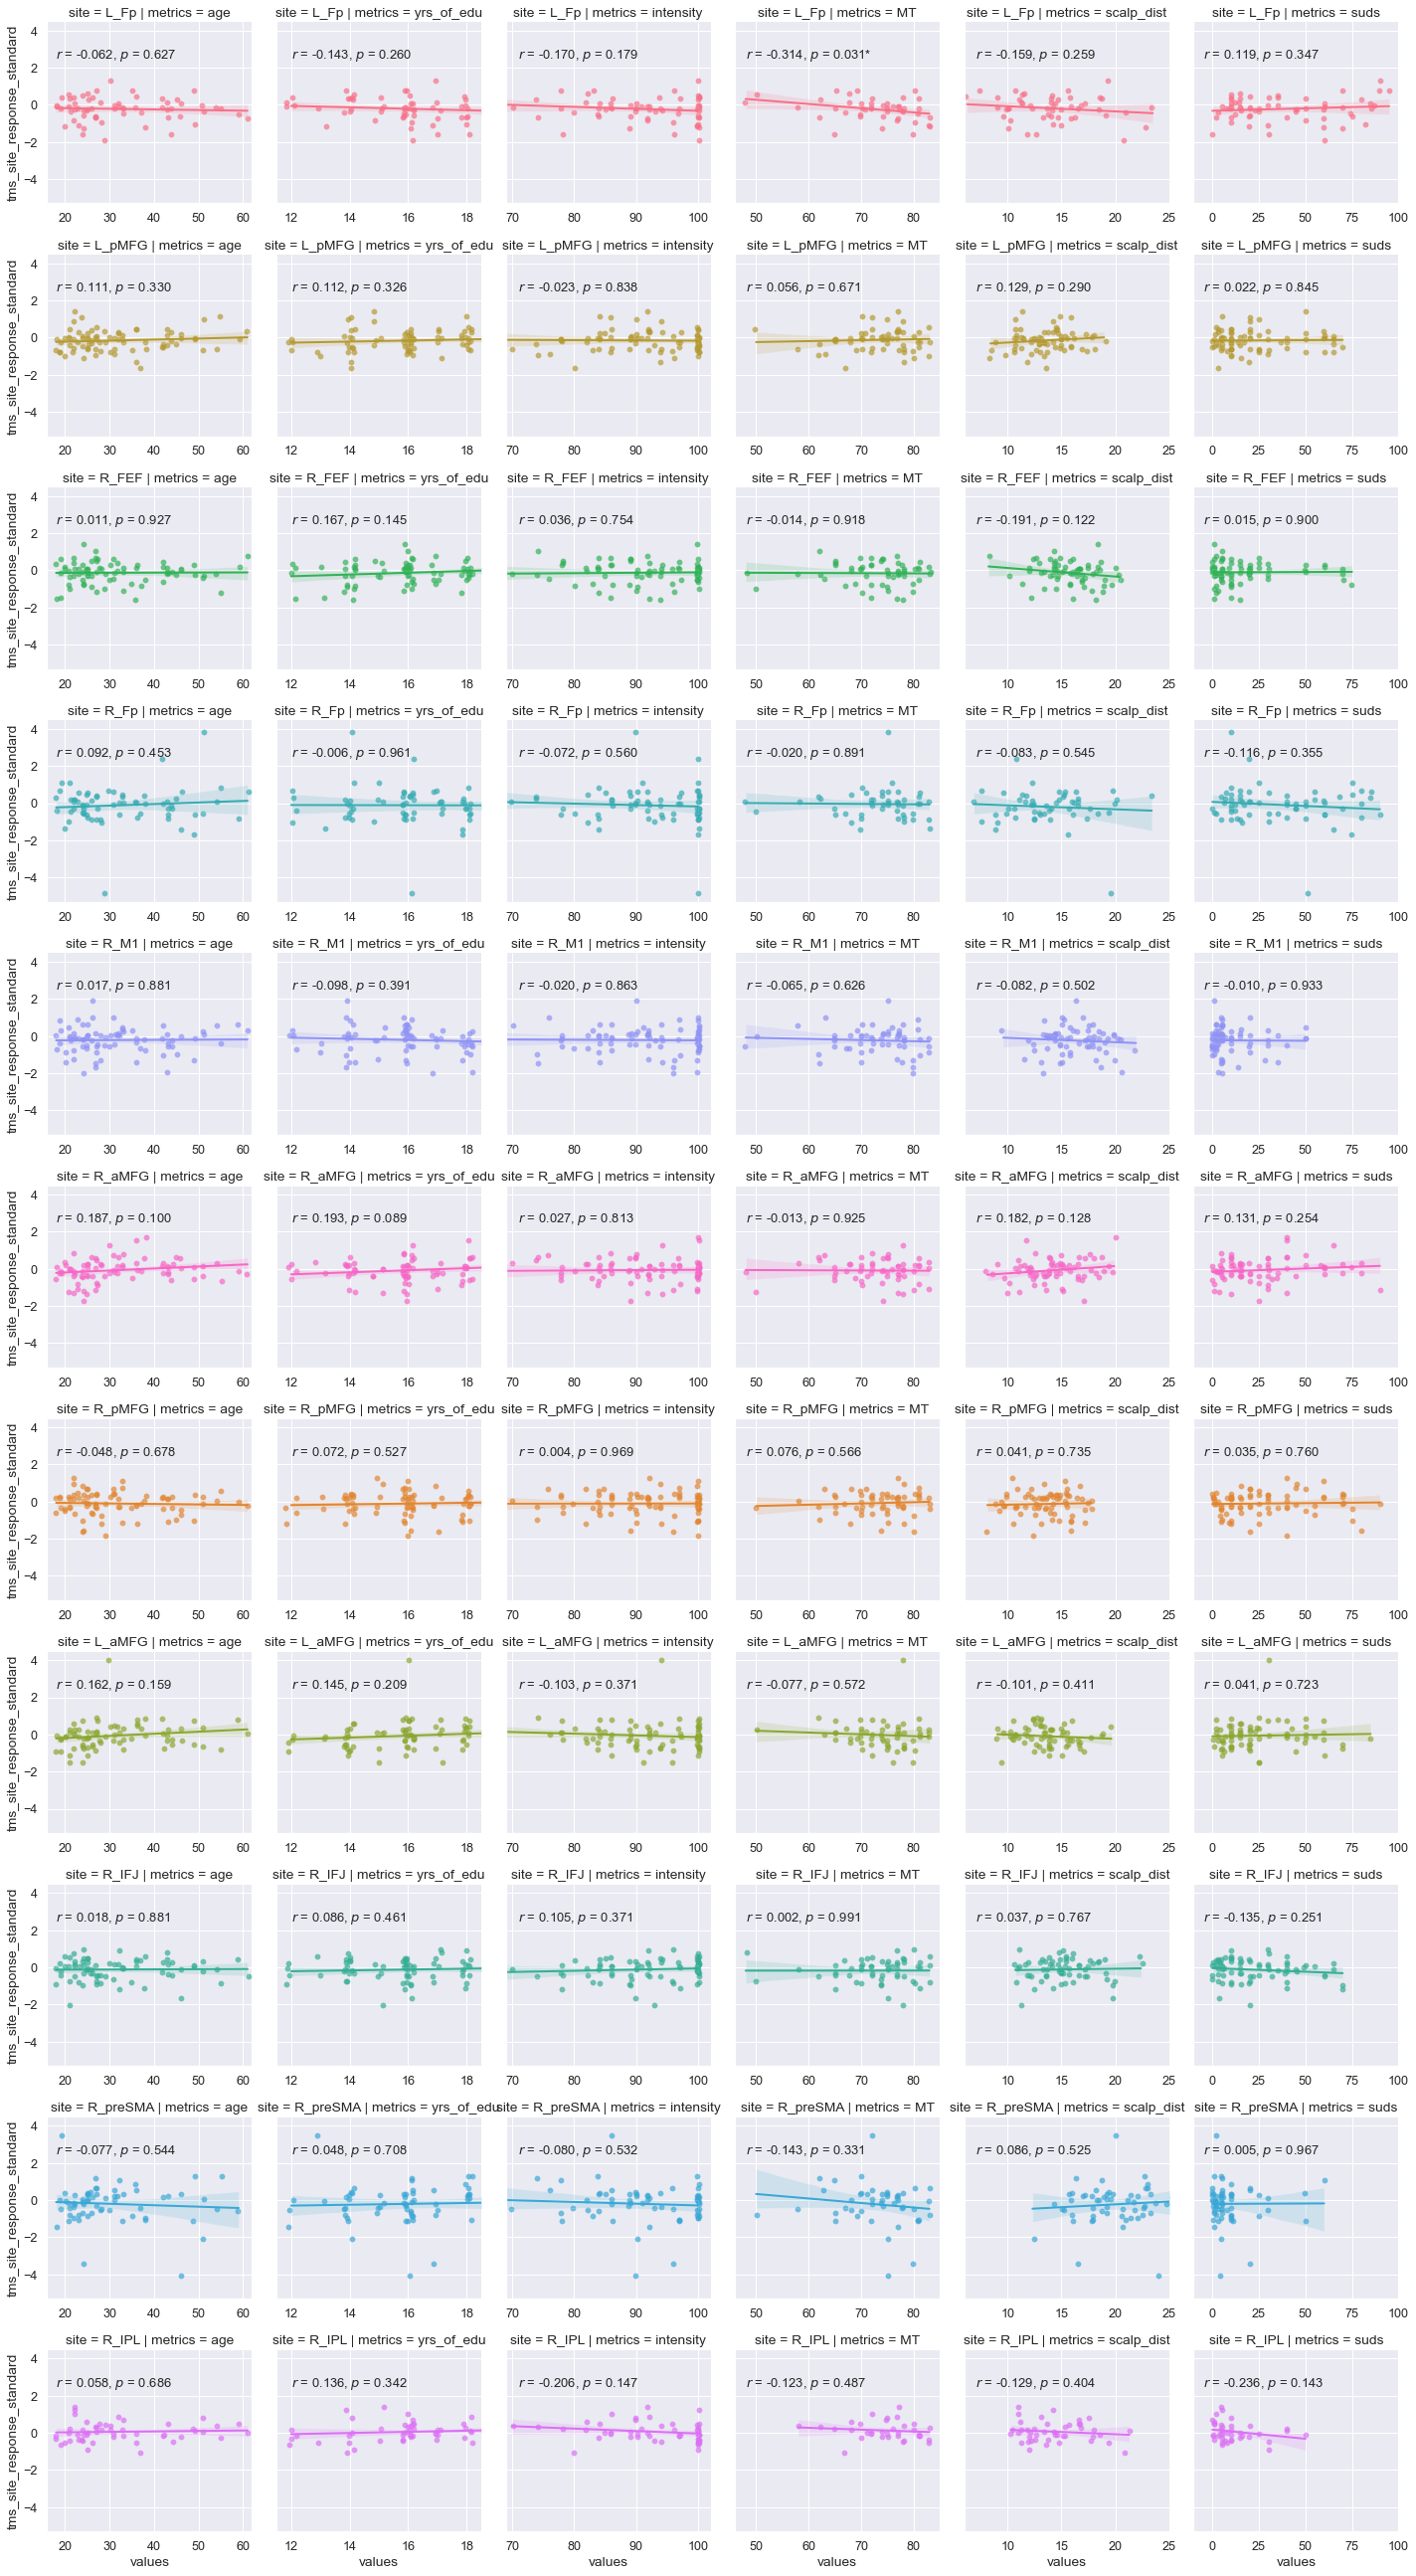

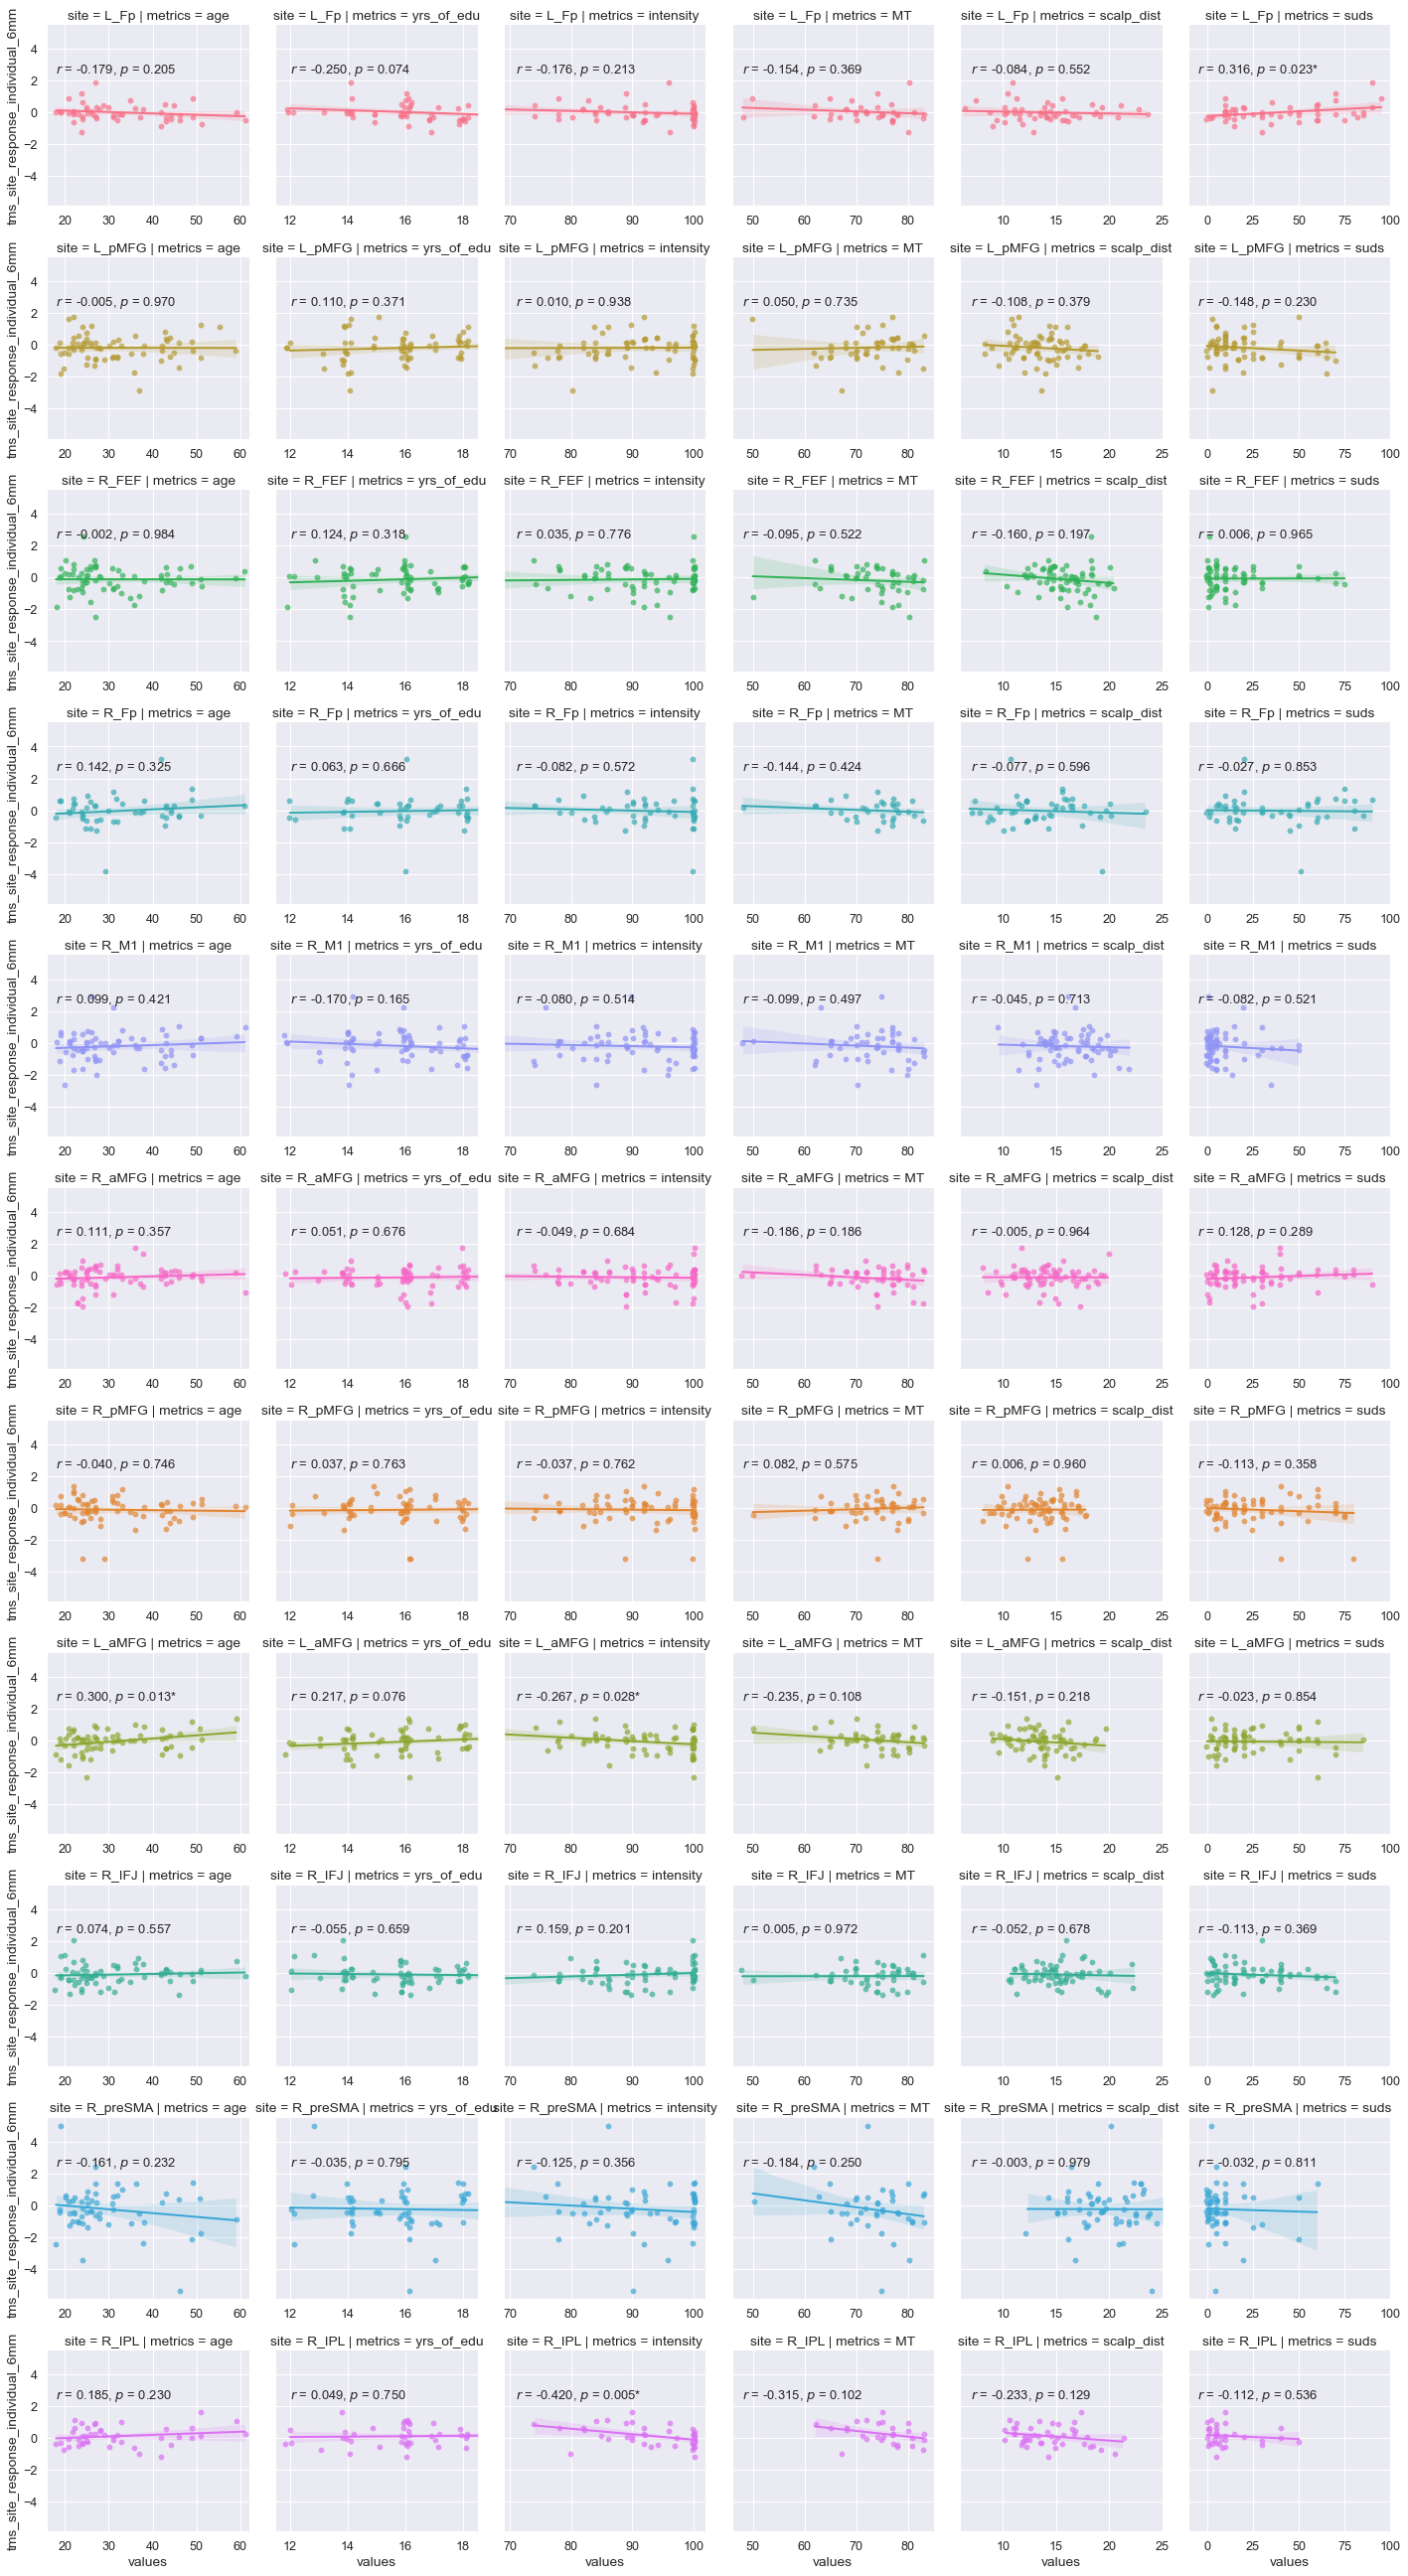

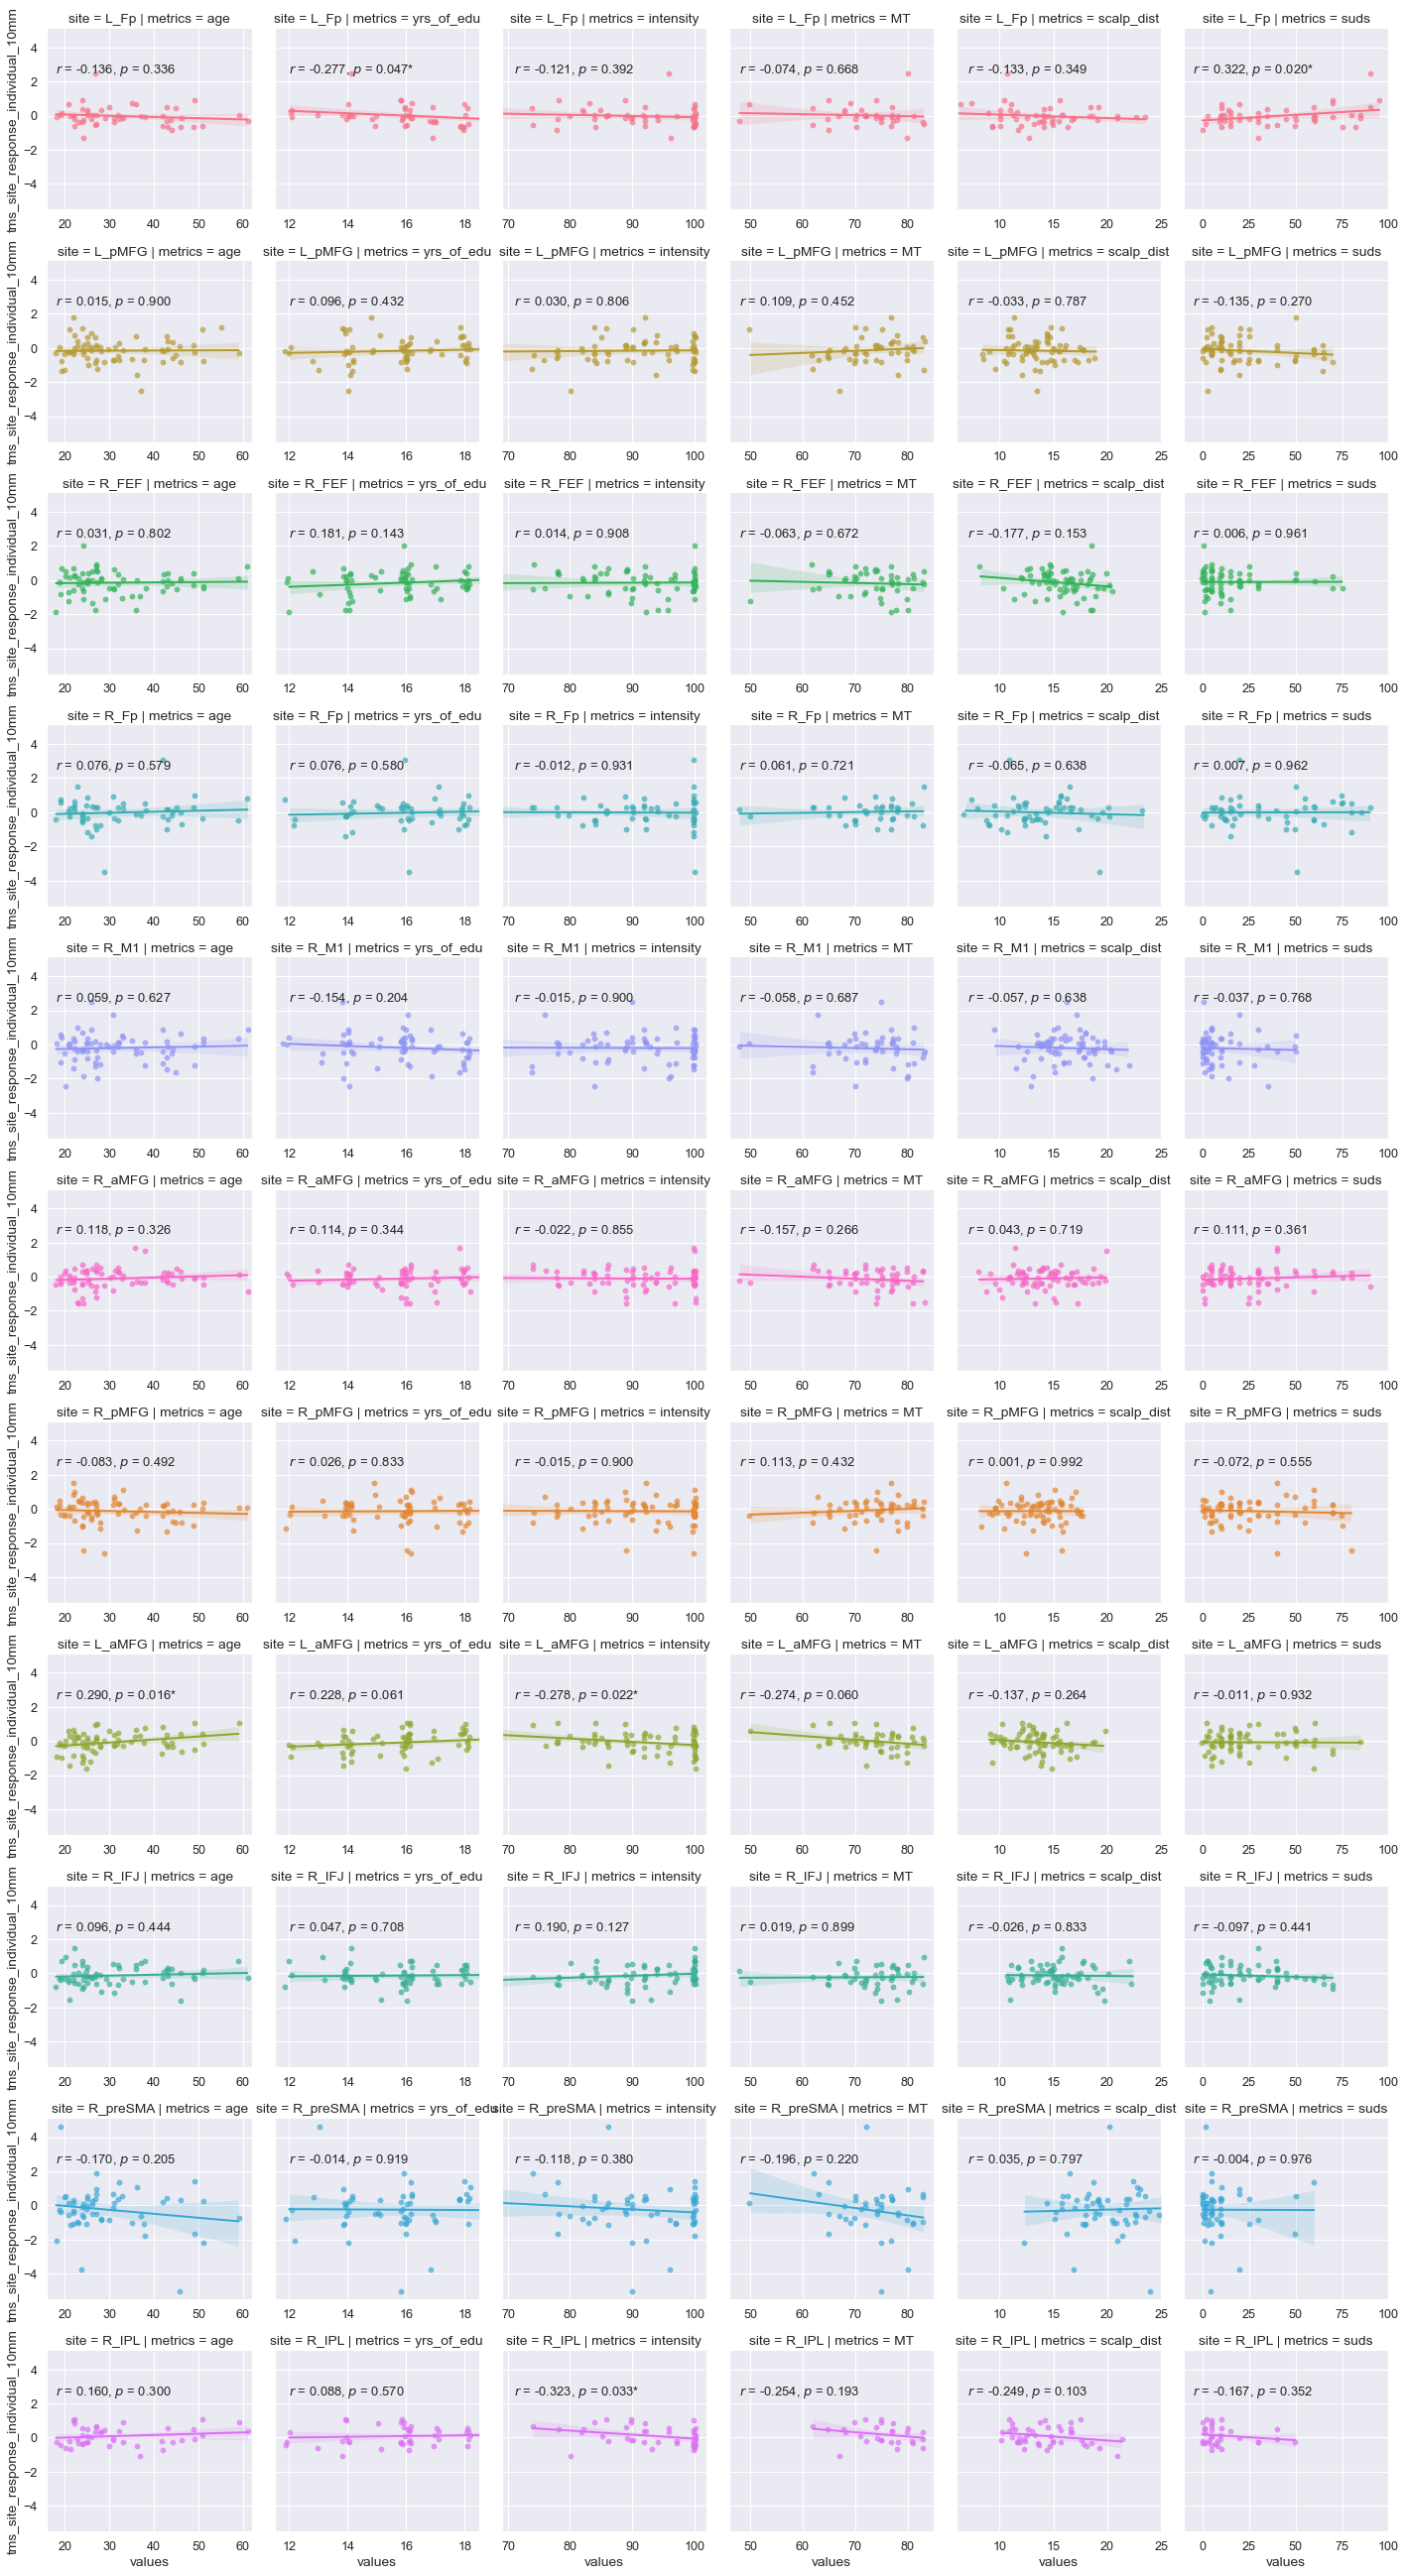

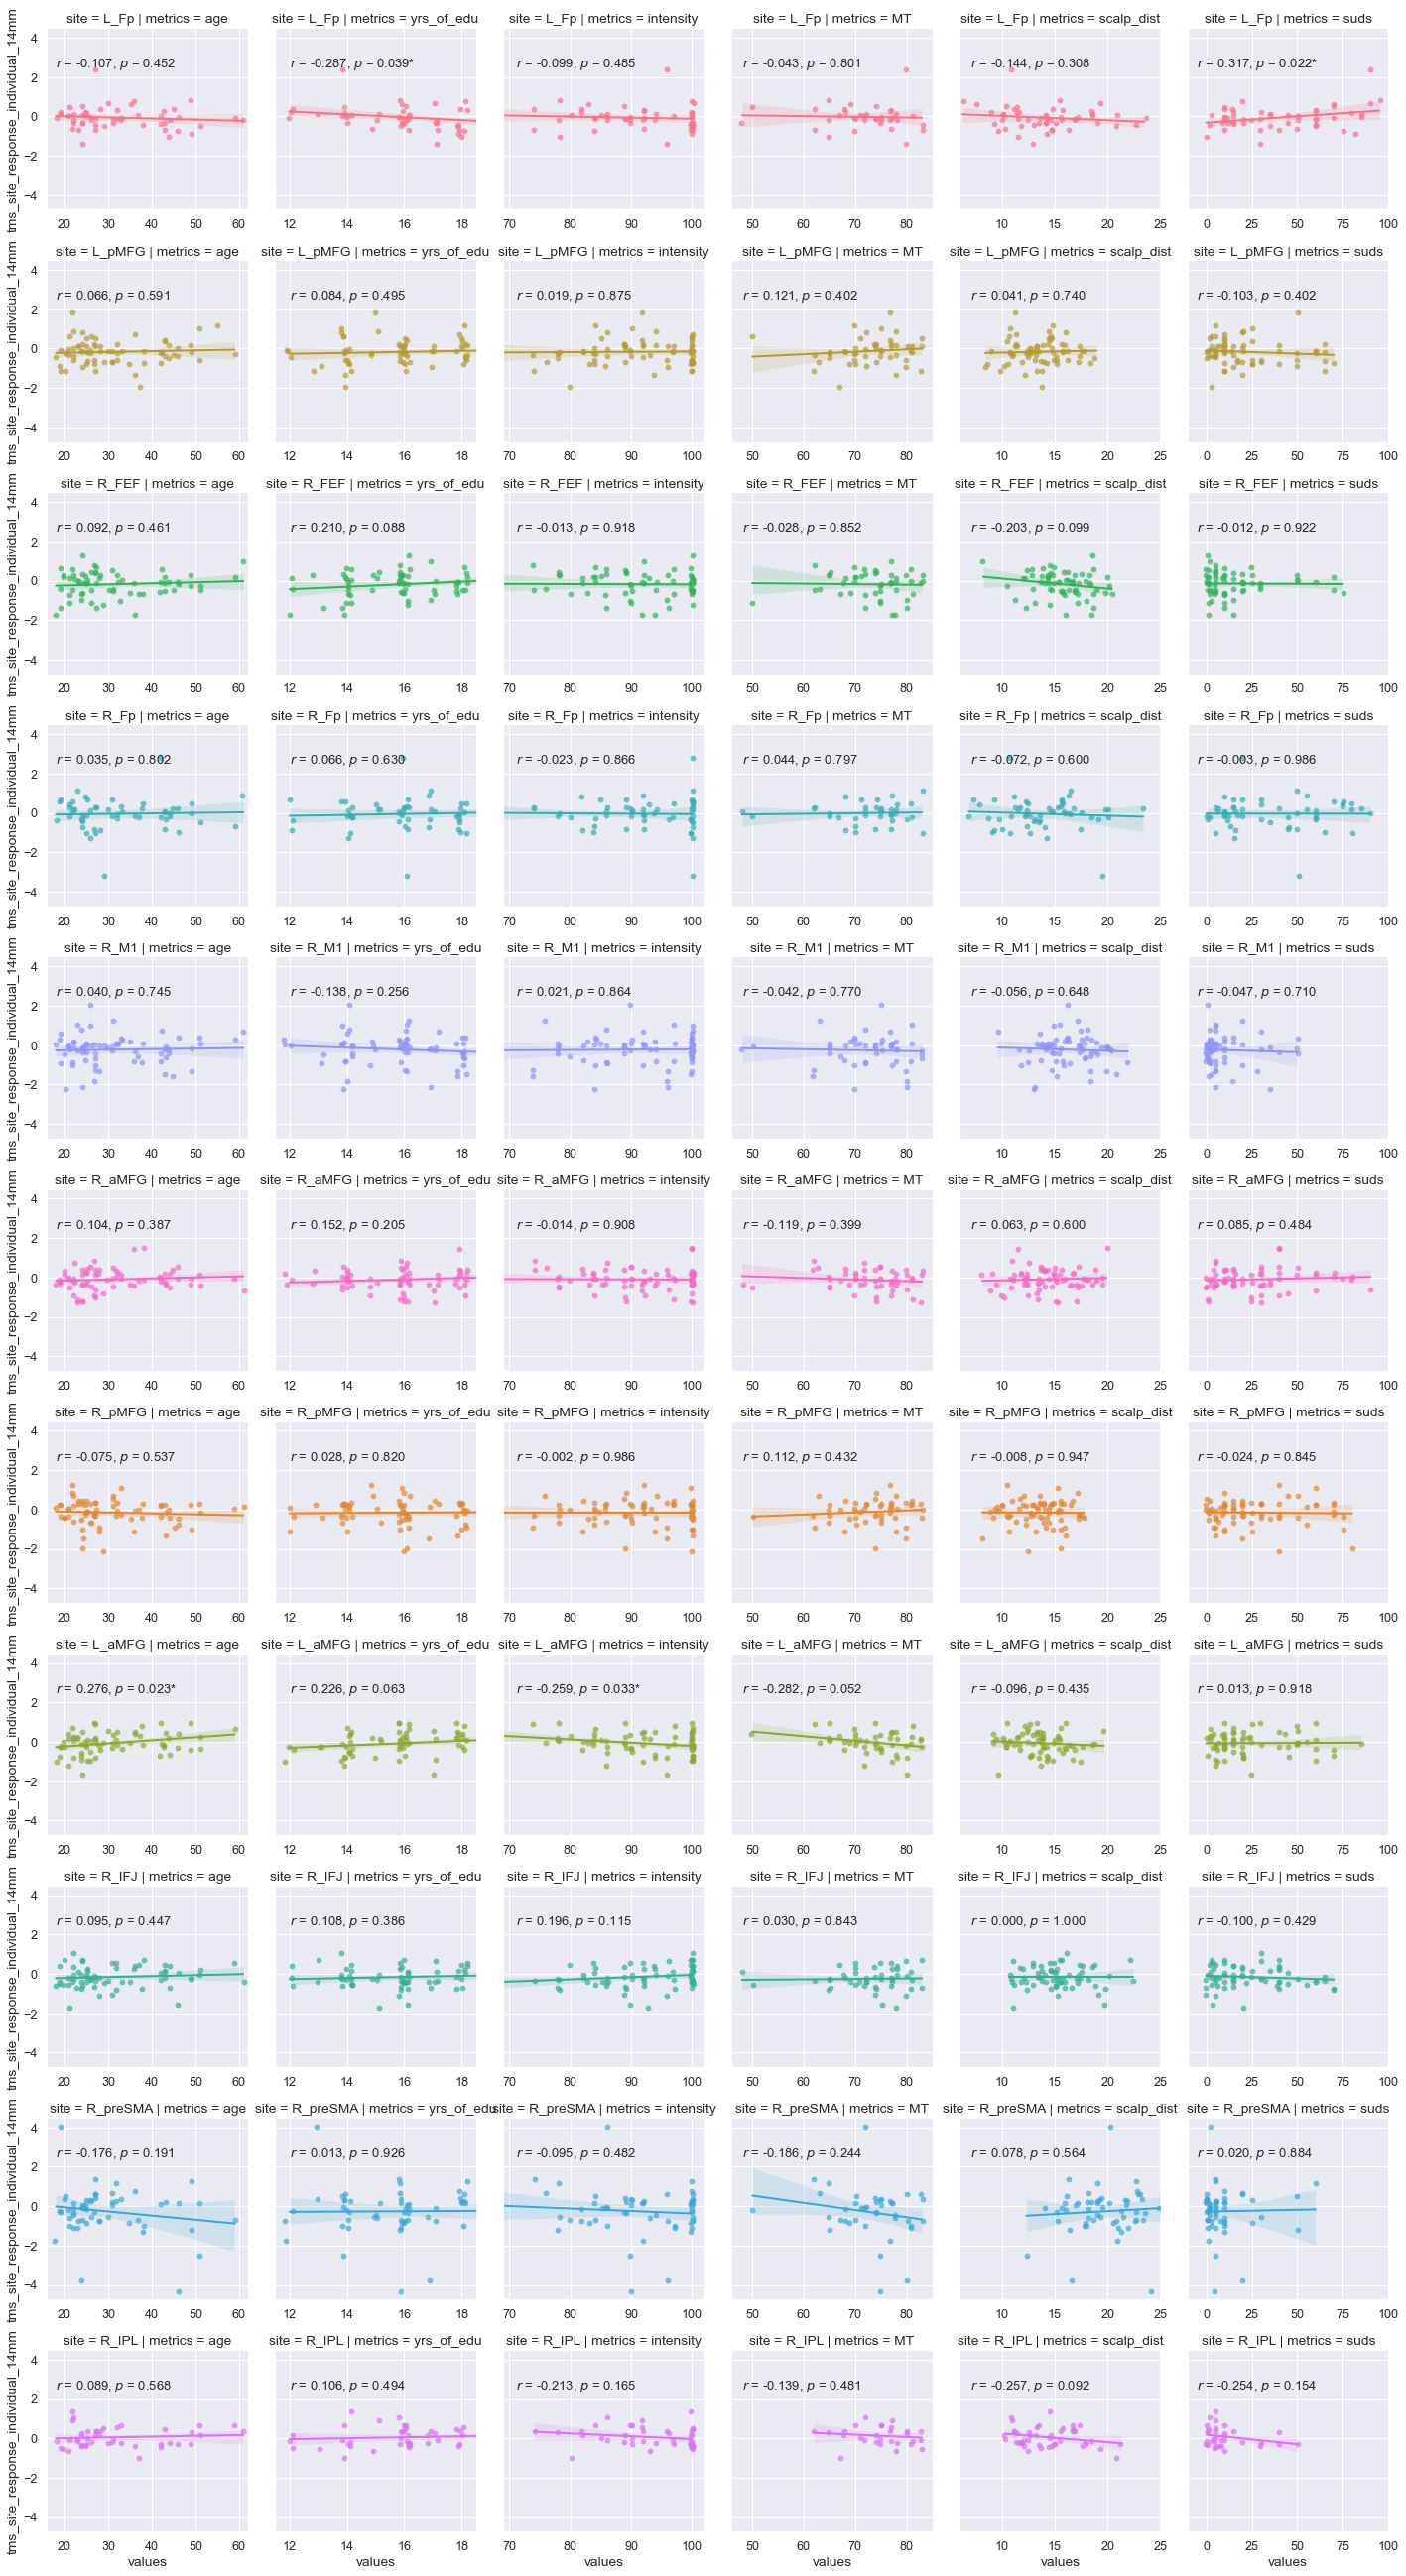

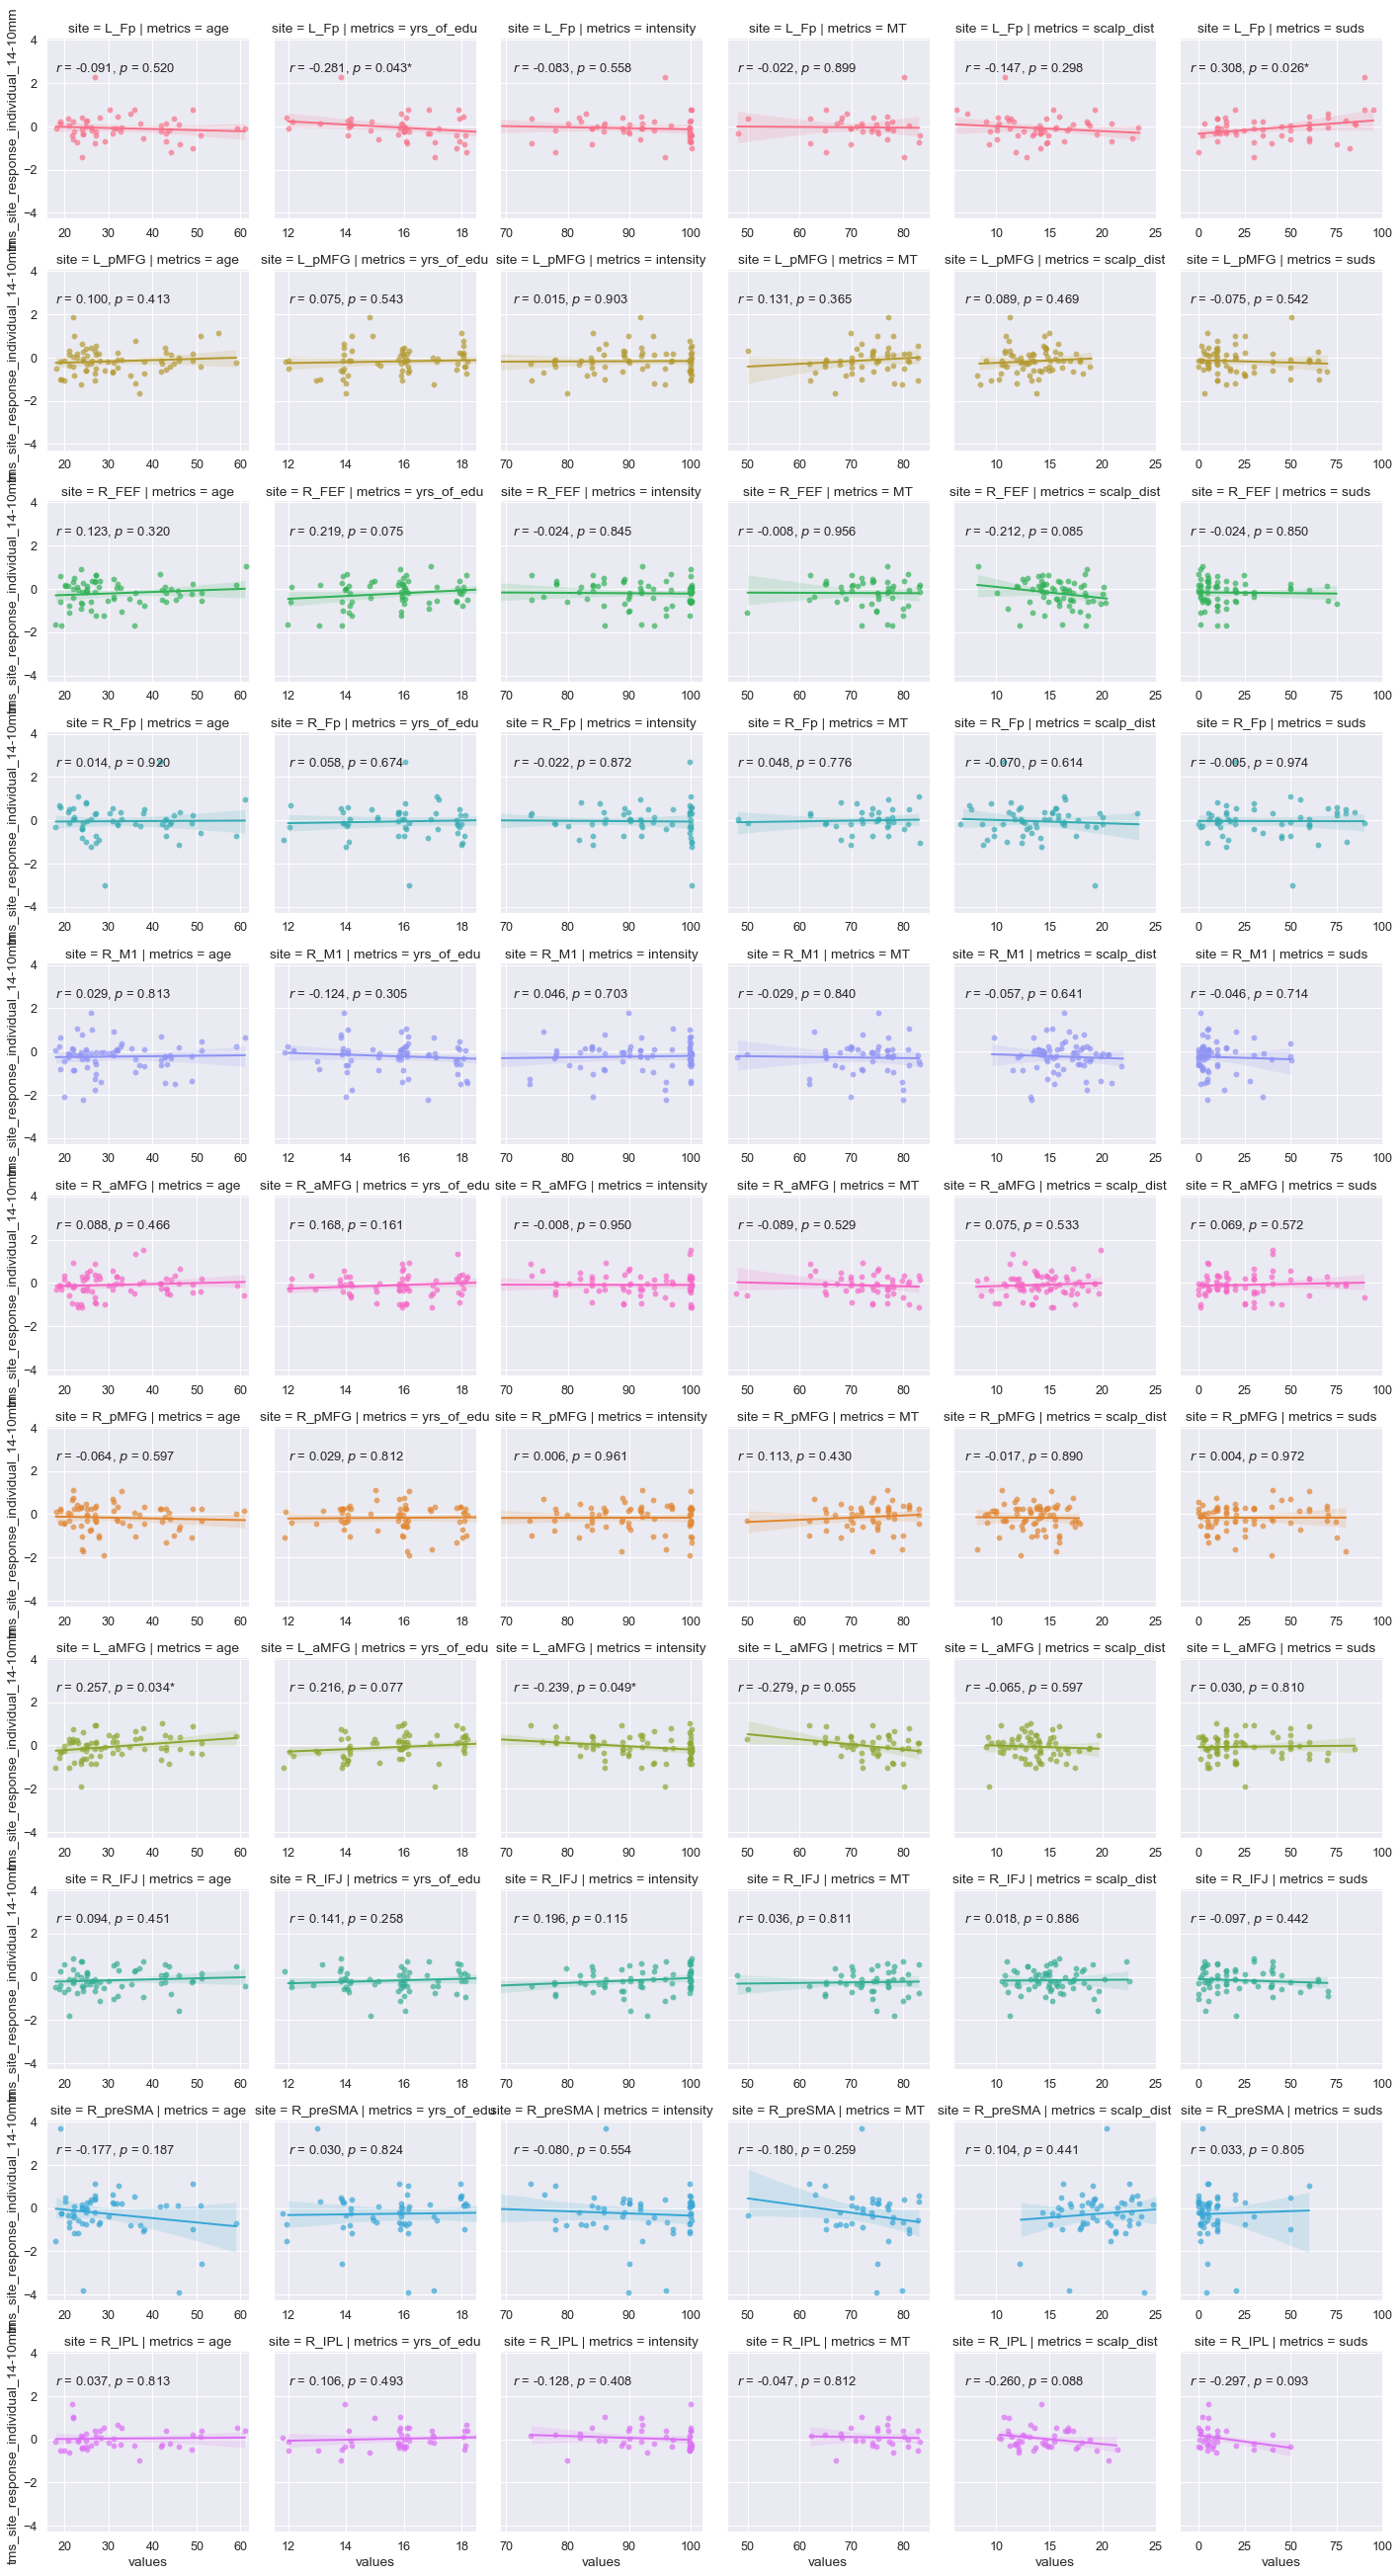

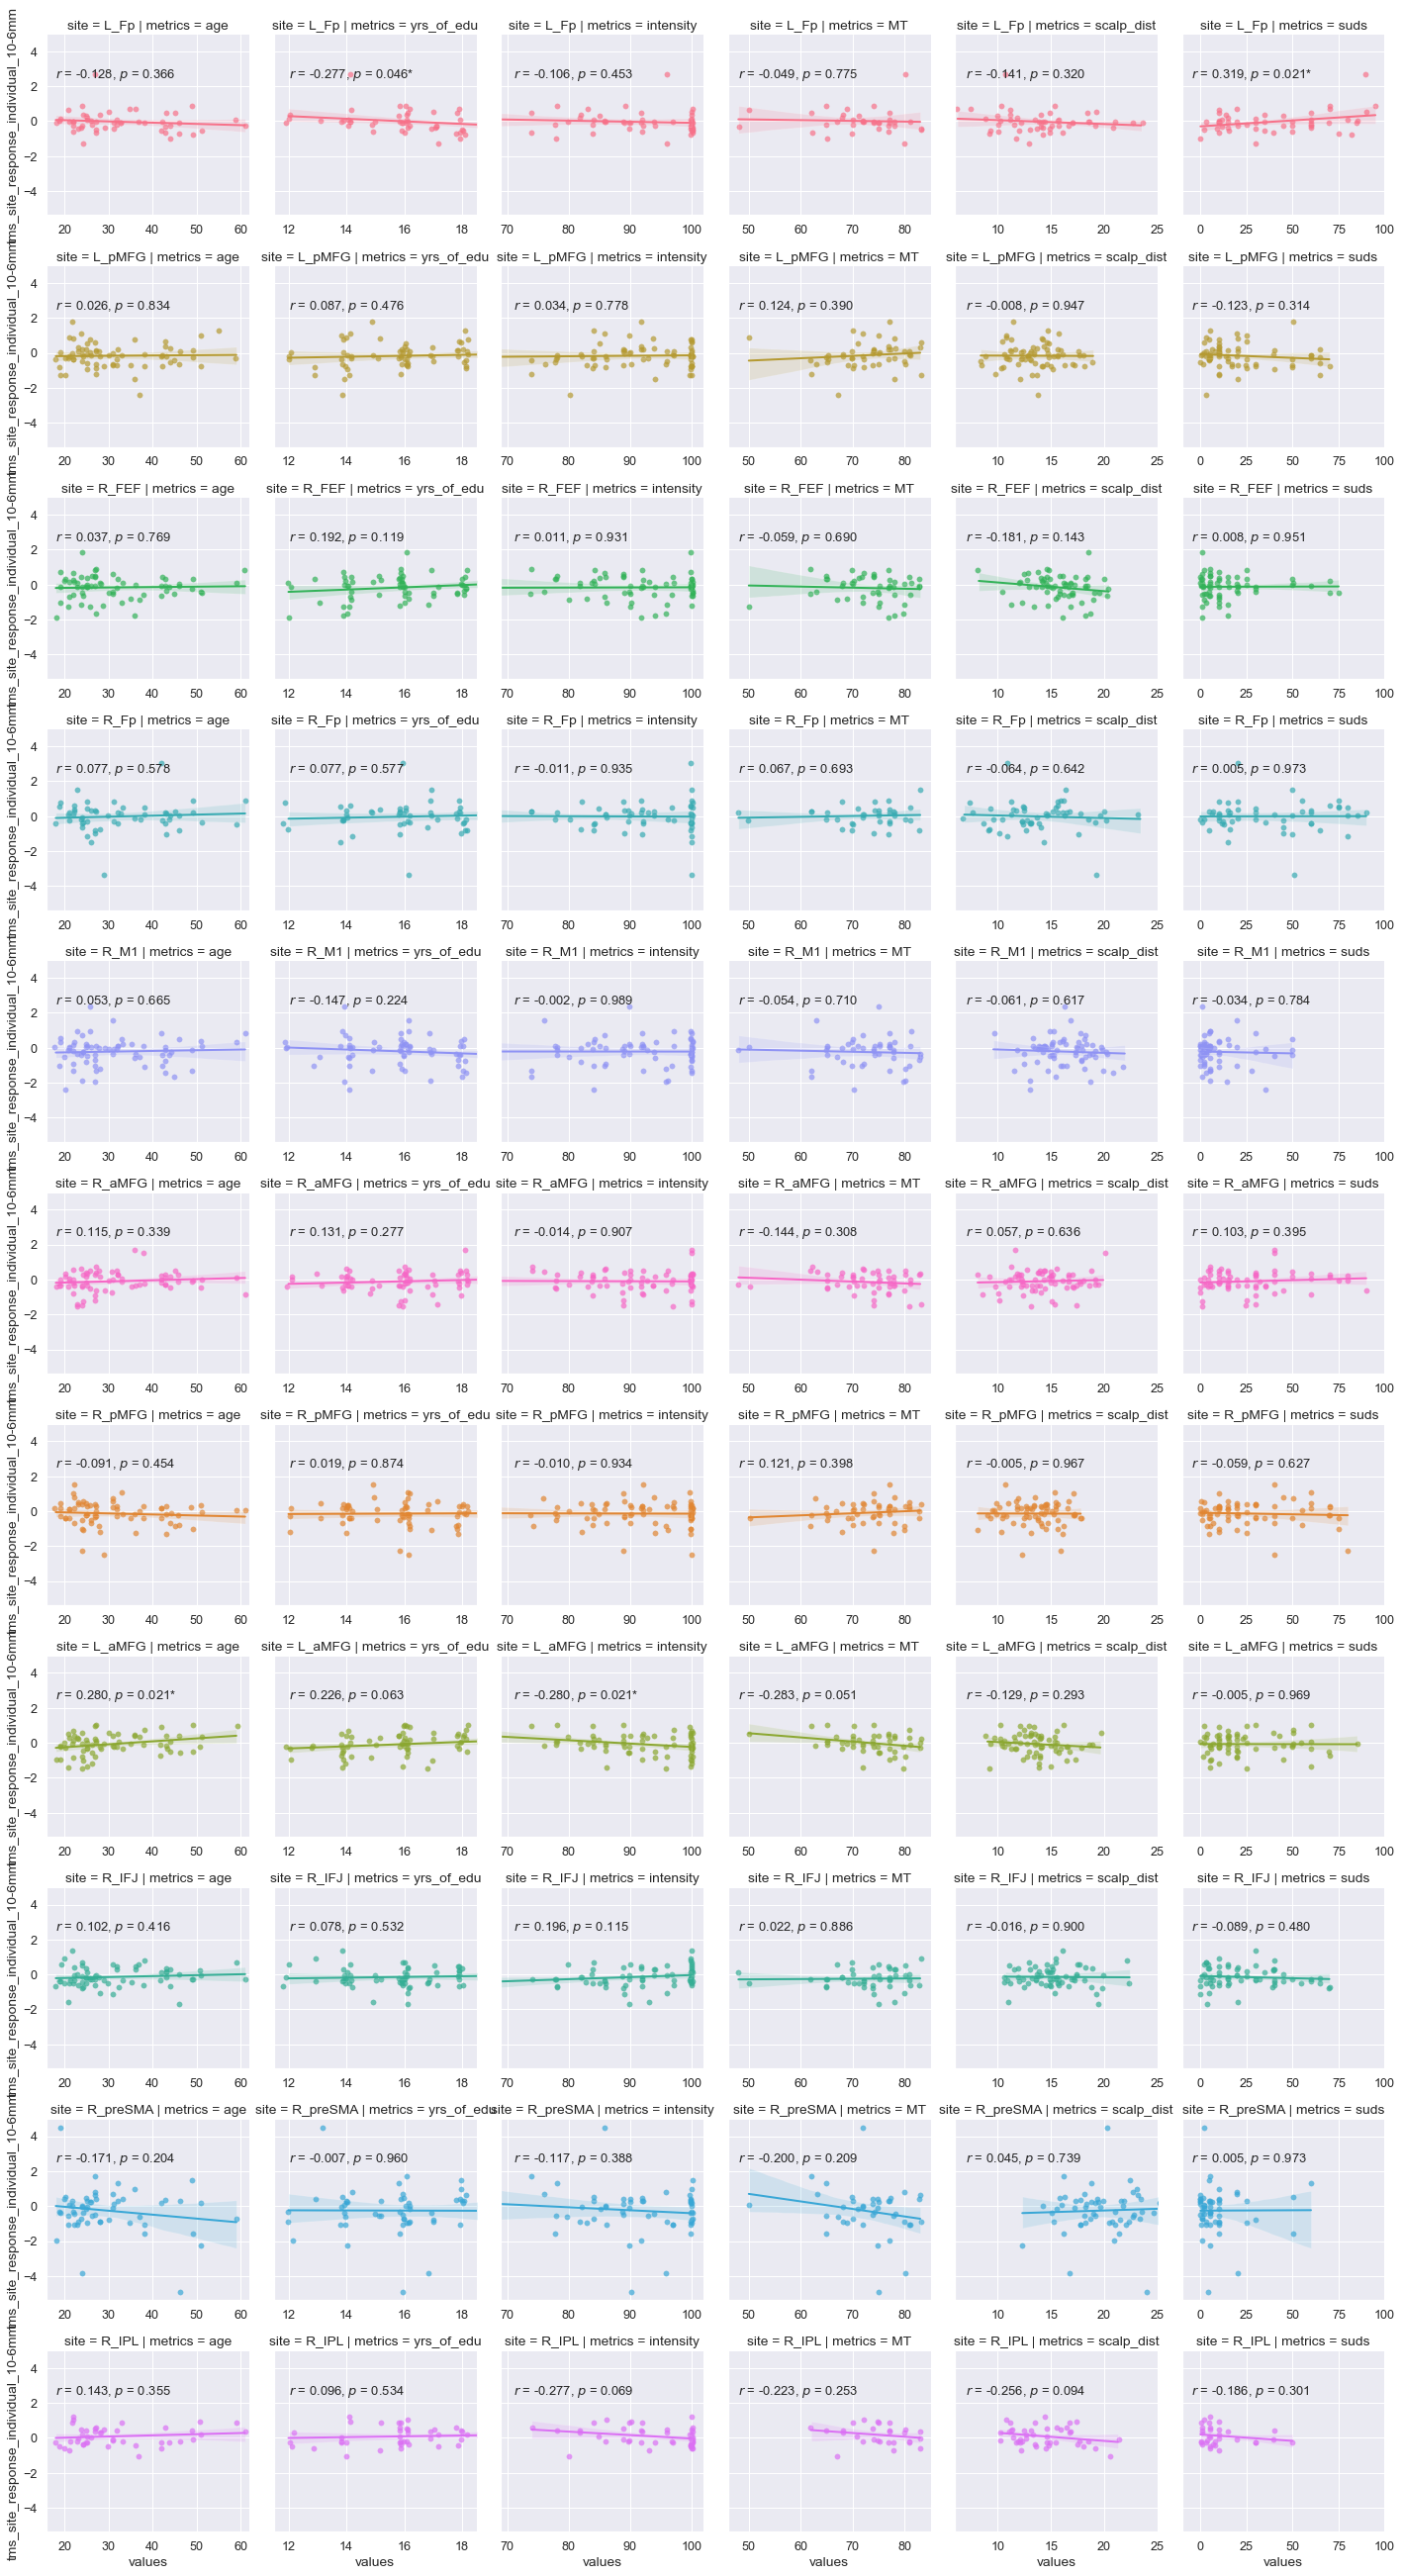

In [8]:
# don't display figures
# %%capture

for var in test_variables:
    f = scatter_plot(plot_data, var)
    f.savefig(out_dir+'/figure2_scatter_plots' + var + '.png', 
              dpi=600, bbox_inches = 'tight', pad_inches = 0.1)
    